# Scaled Interval Score

This is the average Winkler score divided by the one step insample Naive1 or SNaive

## Imports

In [102]:
import pandas as pd
import numpy as np

from forecast_tools.baseline import SNaive, Naive1
from forecast_tools.metrics import mean_absolute_error
from forecast_tools.datasets import load_emergency_dept

import warnings
warnings.filterwarnings('ignore')

## Helper functions

In [46]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    data - arraylike - the training data
    preds - numpy.array, vector of predictions 
    
    Returns:
    -------
    pandas.DataFrame
    '''
    start = pd.date_range(start=data.index.max(), periods=2, 
                          freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

In [89]:
def plot_prediction_intervals(train, preds, intervals, 
                              test=None, show_train_size=None, figsize=(12,4)):
    '''
    Helper function to plot training data, point preds
    and 2 sets of prediction intevals
    
    assume 2 sets of PIs are provided!
    '''
    
    if show_train_size is None:
        show_train_size = len(train)
        
    train = train[-show_train_size:]
    ax = train.plot(figsize=figsize)
    

    mean = preds_as_series(train, preds)
    intervals_80 = preds_as_series(train, intervals[0])
    intervals_90 = preds_as_series(train, intervals[1])

    mean.plot(ax=ax, label='point forecast')

    ax.fill_between(intervals_80.index, mean[0], intervals_80[1], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,mean[0], intervals_80[0], 
                    alpha=0.2,
                    label='80% PI', color='yellow');

    ax.fill_between(intervals_80.index,intervals_80[1], intervals_90[1], 
                    alpha=0.2,
                    label='90% PI', color='purple');

    ax.fill_between(intervals_80.index,intervals_80[0], intervals_90[0], 
                    alpha=0.2,
                    label='90% PI', color='purple');
    
    if test is None:
        ax.legend(['train', 'point forecast', '80%PI', '_ignore','_ignore', '90%PI'], loc=2)
    else:
        test.plot(ax=ax, color='black', marker='o', ls='')
        ax.legend(['train', 'point forecast', 'Test', '80%PI', 
                   '_ignore','_ignore', '90%PI'], loc=2, ncol=5)

## Individual and mean interval score

In [157]:
def winkler_score(l_interval, u_interval, y_t, alpha):
    '''
    Calculates the Winkler score for an observation in 
    an prediction interval.
    
    Winkler scores penalise intervals that do not capture the 
    observation proportional to 2/alpha

    Params:
    -------
    l_interval: float
        Lower prediction interval
        
    u_interval: float
        Upper prediction interval
        
    y_t: float
        Observed ground truth value
        
    alpha: float
        The prediction interval alpha.  For an 80% pred intervals alpha=0.2
        
    Returns:
    -------
    float
    
    Example usage:
    --------------
    ```python
    >>> alpha = 0.2
    >>> interval = [744.54, 773.22]
    >>> y_t = 741.84
    >>> ws = winkler_score(interval, y_t, alpha)
    >>> print(round(ws, 2))
    
    56.68
    ```
    '''
    score = u_interval - l_interval
    if y_t < l_interval:
        score += ((2/alpha) * (l_interval - y_t))
    elif y_t > u_interval:
        score += ((2/alpha) * (y_t - u_interval))
        
    return score

In [158]:
def mean_winkler_score(intervals, observations, alpha):
    '''
    Returns the mean winkler score across a set of 
    intervals and also a numpy.ndarray of individual winkler scores
    
    Params:
    -------
    intervals: array-like
        array of prediction intervals
        
    observations: array-like
        array of ground truth observations
        
    alpha: float
        The prediction interval alpha.  For an 80% pred intervals alpha=0.2
        
    Returns:
    -------
    float, numpy.ndarray
    
    '''
    observations = np.array(observations)
    scores = [winkler_score(l[0], l[1], y_t, alpha) for l, y_t in zip(intervals, observations)]
    scores = np.array(scores)
    print(scores)
    return scores.mean()

## Scaled interval score implementation

In [139]:
def scaled_interval_score(y_true, intervals, y_train, alpha, period=None):
    y_true, y_train = np.array(y_true), np.array(y_train)
    
    if period is None:
        period = 1
        
    in_sample_model = SNaive(period=period)
    in_sample_model.fit(y_train)

    mae_insample = mean_absolute_error(y_train[period:],
                                       in_sample_model.fittedvalues.dropna())
    
    return mean_winkler_score(intervals, y_true, alpha) / mae_insample

## Example with outpatient dataset

In [151]:
TARGET = 0.80
HOLDOUT = 6
URL = 'https://raw.githubusercontent.com/health-data-science-OR/' \
        + 'hpdm097-datasets/master/out_appoints_mth.csv'

appoints = pd.read_csv(URL, index_col='date', parse_dates=True, dayfirst=True)
appoints.index.freq = 'MS'

# train-test split
train = appoints[:-HOLDOUT]
test_out = appoints[-HOLDOUT:]

model = Naive1()

# returns 80 and 90% prediction intervals by default.
model.fit(train)
preds, intervals_out = model.predict(6, return_predict_int=True)

In [155]:
msis = scaled_interval_score(test_out, intervals_out[0], train, alpha=1-TARGET, period=12)
print(msis)

[25771.07314115 36445.80115312 44636.80804604 51542.1462823
 57625.87139673 63125.97931976]
6.51227581009931


## Example with `forecast_tools` ED dataset

In [156]:
TARGET = 0.80
HOLDOUT = 14
PERIOD = 7

attends = load_emergency_dept()

# train-test split
train = attends[:-HOLDOUT]
test_ed = attends[-HOLDOUT:]

# print(train.head())

model = SNaive(PERIOD)

# returns 80 and 90% prediction intervals by default.
preds, intervals_ed = model.fit_predict(train, HOLDOUT, return_predict_int=True)

msis = scaled_interval_score(test_ed, intervals_ed[0], train, alpha=1-TARGET, period=PERIOD)
print(f'Mean scaled interval score: {msis}')

[58.61002824962492 58.61002824962492 58.610028249624946 58.610028249624946
 58.610028249624946 58.61002824962492 58.61002824962492 82.88709684168981
 array([208.45161263]) 82.88709684168984 82.88709684168984
 82.88709684168984 82.88709684168981 82.88709684168981]
Mean scaled interval score: [2.85616841]


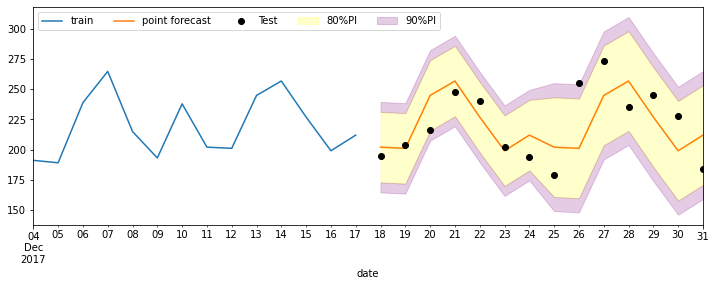

In [143]:
plot_prediction_intervals(train, preds, intervals_ed, test=test_ed, show_train_size=14)

In [144]:
appoints.head()

,out_apts
date,
2014-04-01,40921
2014-05-01,42205
2014-06-01,58850
2014-07-01,45174
2014-08-01,41427


In [145]:
attends.head()

,arrivals
date,
2017-01-22,170
2017-01-23,196
2017-01-24,186
2017-01-25,200
2017-01-26,228


In [146]:
intervals_ed[0].shape

(14, 2)

In [147]:
intervals_out[0].shape

(6, 2)

In [148]:
test_out

,out_apts
date,
2017-11-01,47563
2017-12-01,40828
2018-01-01,56148
2018-02-01,45342
2018-03-01,43741
2018-04-01,45907


In [134]:
test_ed

,arrivals
date,
2017-12-18,195
2017-12-19,204
2017-12-20,216
2017-12-21,248
2017-12-22,240
2017-12-23,202
2017-12-24,194
2017-12-25,179
2017-12-26,255
